# Jan Izydorczyk

## Sprawozdanie 2

### Kwadraty bez trójkątów (za to z wysokim stężeniem konwolucji)

In [52]:
import torch as pt
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as fun
import torchvision as ptv

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [310]:
def imshow(img, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.imshow(img.squeeze(), cmap='gray')
    return ax
    
def norm(img):
    return (img - pt.min(img)) / (pt.max(img) - pt.min(img))

In [311]:
img = Image.open('./data/lab02/furniture.png')

## Oryginalny obraz

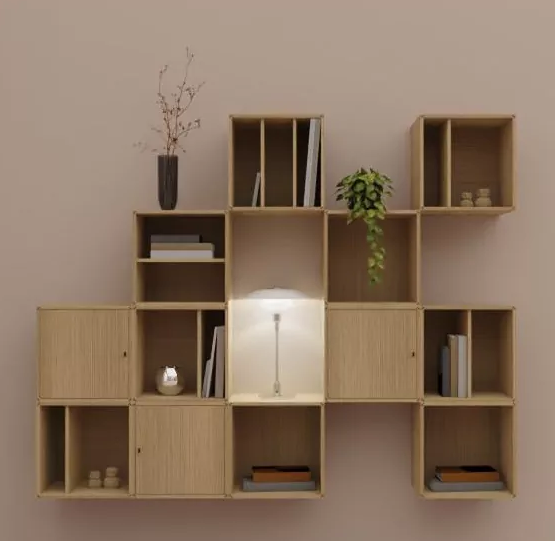

In [312]:
img

In [313]:
img = transforms.ToTensor()(img)

In [314]:
weights = pt.tensor([0.1, 0.8, 0.1]).reshape(3, 1, 1)
gray_img = pt.sum((img * weights), axis=0, keepdims=True)

## Obraz zredukowany do jednego wymiaru

<AxesSubplot:>

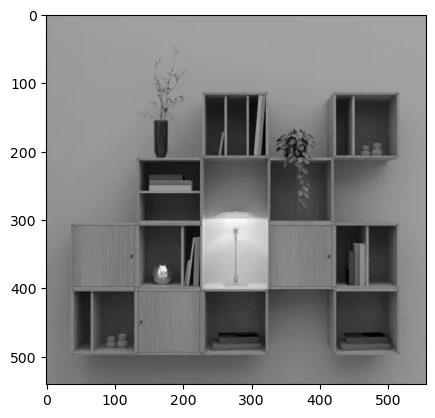

In [315]:
imshow(gray_img)

In [117]:
pooled_img = fun.avg_pool2d(gray_img, 4)

## Obraz zpoolowany czterokrotnie

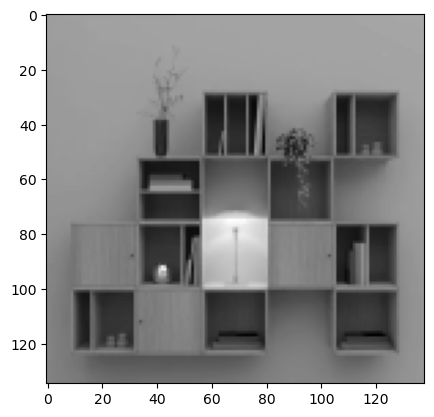

In [163]:
imshow(pooled_img)

In [119]:
def gauss(img,  n: int):
    return transforms.GaussianBlur(n)(img)

In [122]:
gauss_img = gauss(pooled_img, 7)

## Obraz rozmyty

Kernel wielkości $7\times 7$

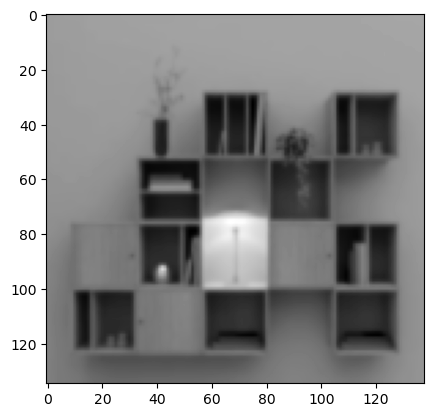

In [164]:
imshow(gauss_img)

In [325]:
a = pt.tensor([[1, 2, 1], [0, 0, 0], [-1,-2,-1]], dtype=pt.float32).reshape(1, 1, 3, 3)

b = pt.tensor([[1, 0,-1], [2, 0,-2], [1, 0,-1]], dtype=pt.float32).reshape(1, 1, 3, 3)

Specjalnie nie uzywam paddingu, poniewaz jest on ustawiany na bialy kolor, co psuje wykrywanie kwadratow.

In [326]:
padding = 0
vert_img = fun.conv2d(gauss_img.reshape(1, *gauss_img.shape), a, padding=padding)
hor_img = fun.conv2d(gauss_img.reshape(1, *gauss_img.shape), b, padding=padding)

## Filtr Horyzontalny

<AxesSubplot:>

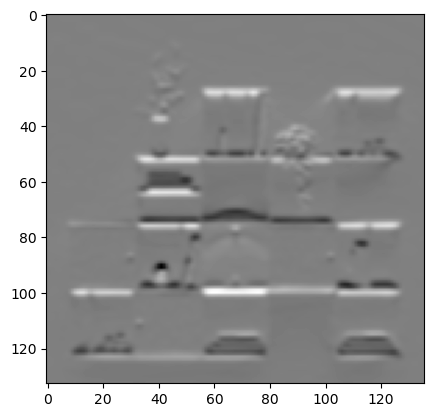

In [327]:
imshow(vert_img)

## Filtr wertykalny

<AxesSubplot:>

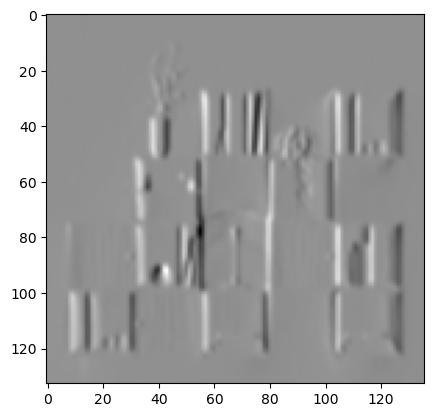

In [328]:
imshow(hor_img)

In [329]:
grad_img = pt.sqrt(vert_img ** 2 + hor_img ** 2)

## Gradient krawędzi

<AxesSubplot:>

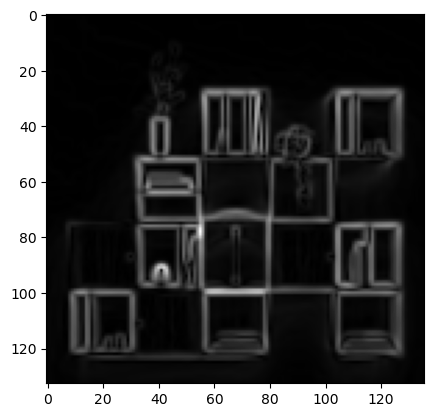

In [330]:
imshow(grad_img)

In [331]:
threshold = 0.5
relu_img = nn.ReLU()(grad_img - threshold)
relu_img = norm(relu_img)

## Przefiltrowany i znormalizowany gradient 

$RELU(x - 0.5)$

<AxesSubplot:>

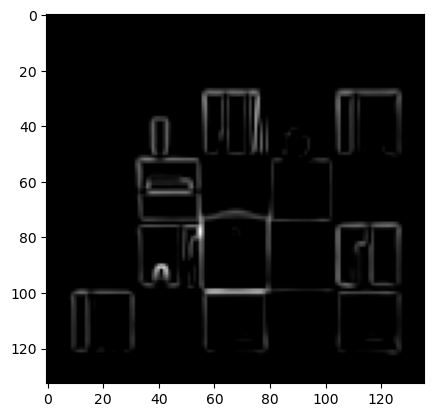

In [332]:
imshow(relu_img)

## Kernele dla transforamcji Hough

Wielkości od 17 do 39

In [333]:
hough_kernels = []

for n in range(17, 40 + 1, 2):
    kernel = pt.ones((n, n))
    kernel[1:-1, 1:-1] = 0
    hough_kernels.append(kernel.reshape(1, 1, *kernel.shape))

### Kernel 17 x 17 

In [334]:
print(hough_kernels[0])

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0

In [335]:
import math
pads = [hough_kernel.shape[-1] // 2  for hough_kernel in hough_kernels ]

votes = [fun.conv_transpose2d(relu_img, hough_kernel, padding=pad).squeeze() for (hough_kernel, pad) in zip(hough_kernels, pads)]

In [336]:
rect_img = pt.stack(votes)

## Obraz po zastosowaniu róznych kerneli

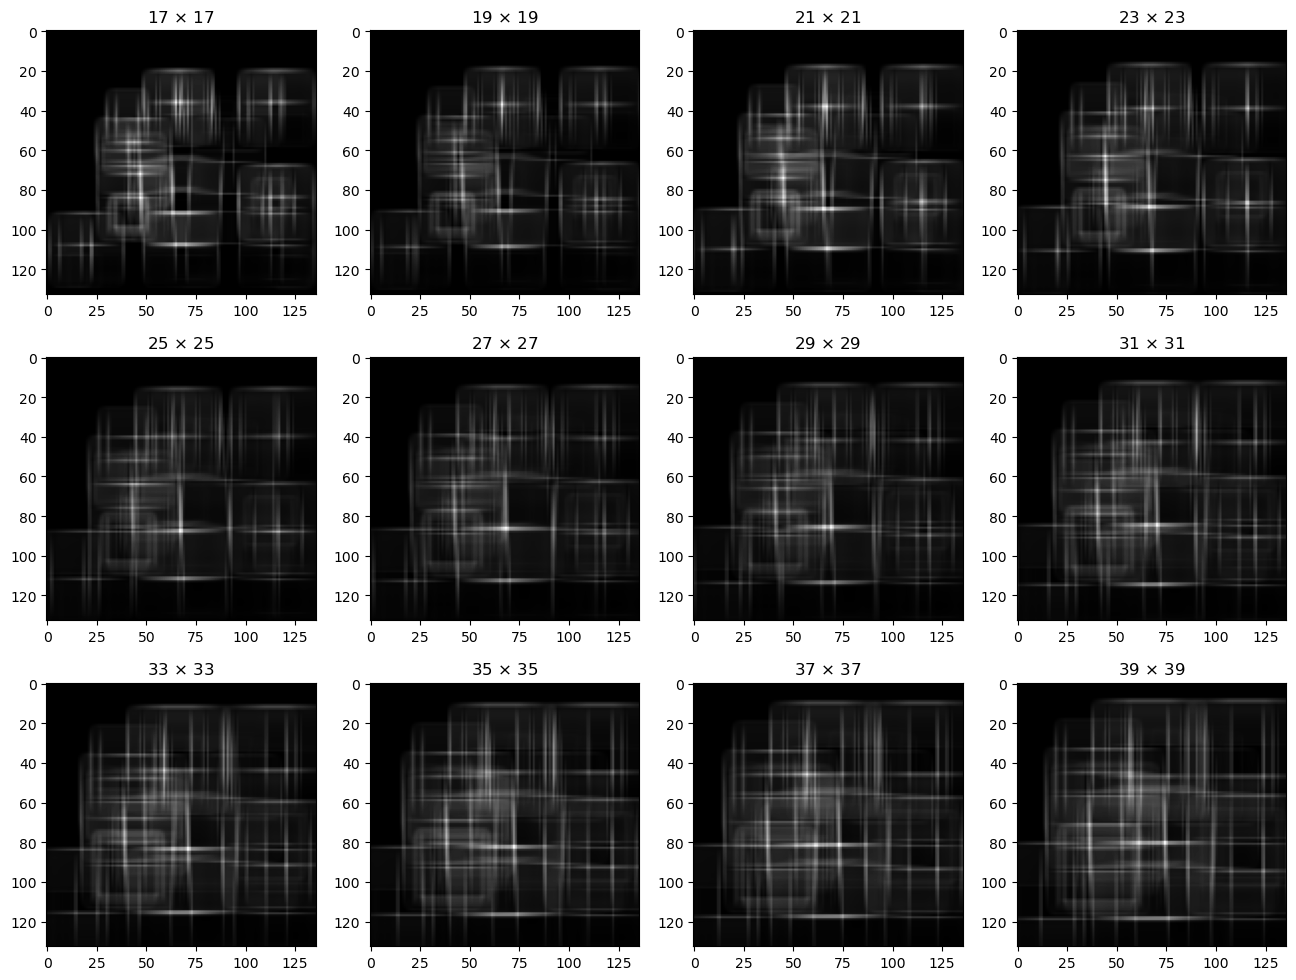

In [413]:
fig, axs = plt.subplots(3, 4, figsize=(4 * 4, 3 * 4))

for ax, vote, ker in zip(axs.flatten(), votes, hough_kernels):
    imshow(vote, ax)
    ax.set_title(fr'{ker.shape[-1]} $\times$ {ker.shape[-1]}')
    
plt.show()

In [360]:
thresholds = pt.linspace(14, 14 + 12, rect_img.shape[0]).reshape(-1, 1, 1)
relu_rect_img = norm(nn.ReLU()(rect_img - thresholds))

## Wyniki kerneli po przefiltrowaniu

Threshold rósł liniowo, względem wielkości kernela

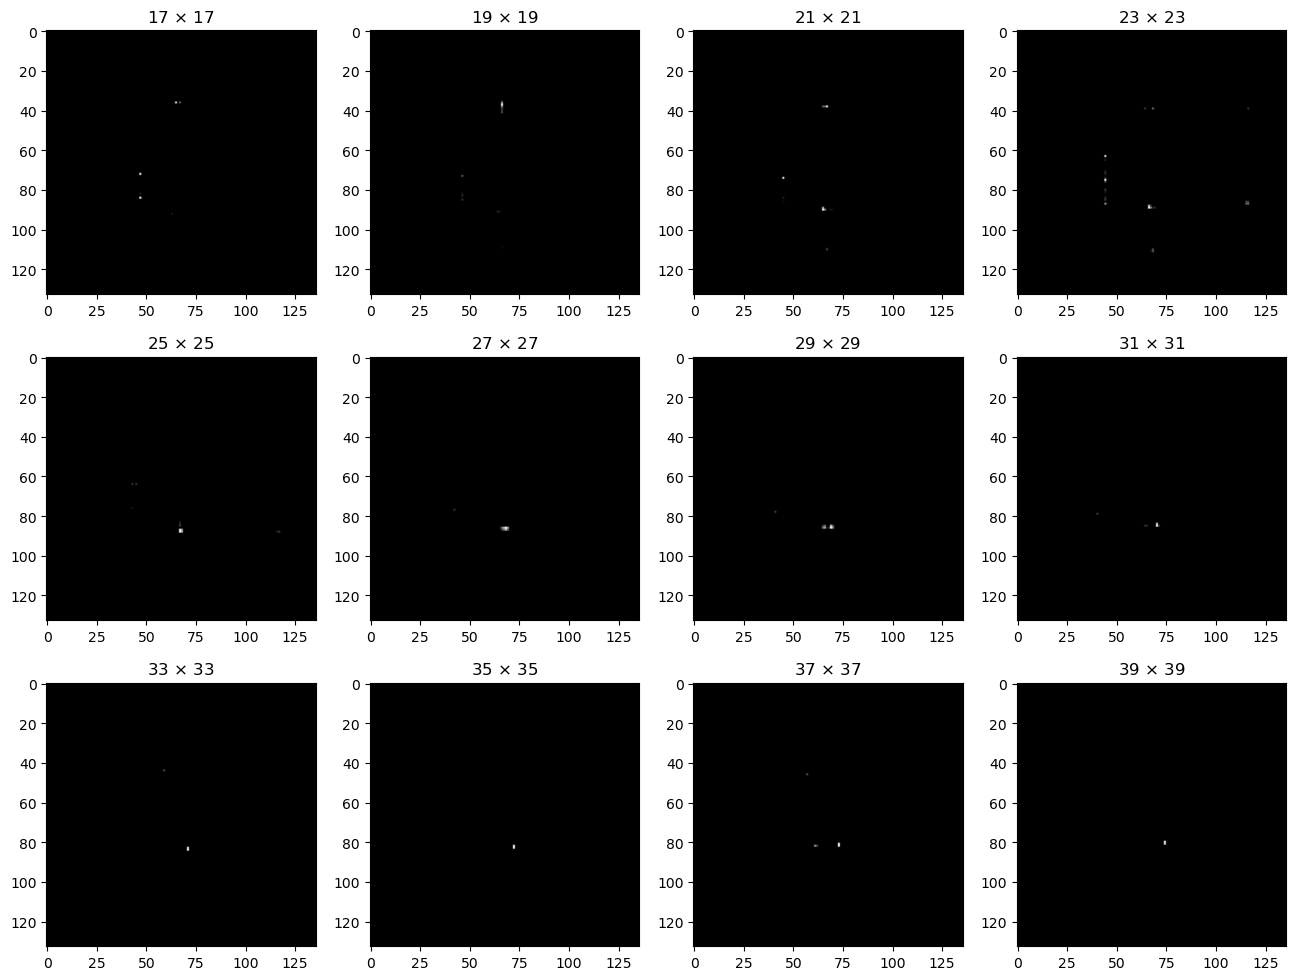

In [414]:
fig, axs = plt.subplots(3, 4, figsize=(4 * 4, 3 * 4))

for ax, relu_rect_channel, ker in zip(axs.flatten(), relu_rect_img, hough_kernels):
    imshow(relu_rect_channel, ax)
    ax.set_title(fr'{ker.shape[-1]} $\times$ {ker.shape[-1]}')
    
plt.show()

In [362]:
rev_votes = [fun.conv_transpose2d(relu_img_channel.reshape(1, 1, *(relu_img_channel.shape)), hough_kernel, padding=pad) for (relu_img_channel, hough_kernel, pad) in zip(relu_rect_img, hough_kernels, pads)]

## Transpozycja przefiltrowanych kerneli

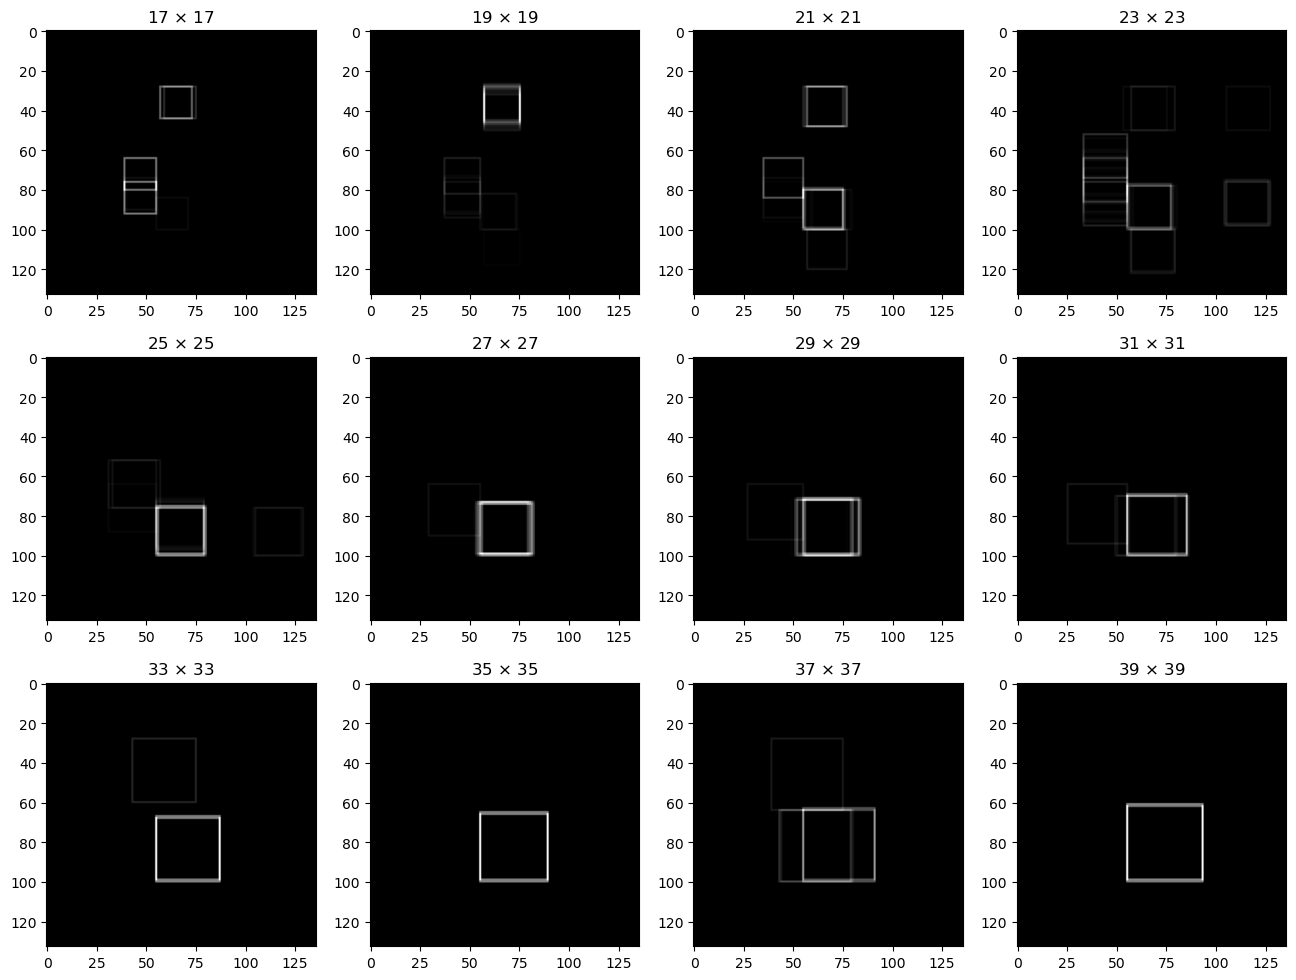

In [415]:
fig, axs = plt.subplots(3, 4, figsize=(4 * 4, 3 * 4))

for ax, rev_vote, ker in zip(axs.flatten(), rev_votes, hough_kernels):
    # imshow(pt.where(rev_vote > 0.5, 1, 0), ax)
    imshow(rev_vote, ax)
    ax.set_title(fr'{ker.shape[-1]} $\times$ {ker.shape[-1]}')
    
plt.show()

In [401]:
norm_rev_votes = [norm(rev_vote) for rev_vote in rev_votes]
final_rec_img = pt.max(pt.stack(norm_rev_votes), axis=0).values.squeeze()
final_rec_img = fun.pad(final_rec_img, (1, 1, 1, 1))

## Nałożenie na siebie znormalizowanych kerneli

Biorąc max z każdego kernela

<AxesSubplot:>

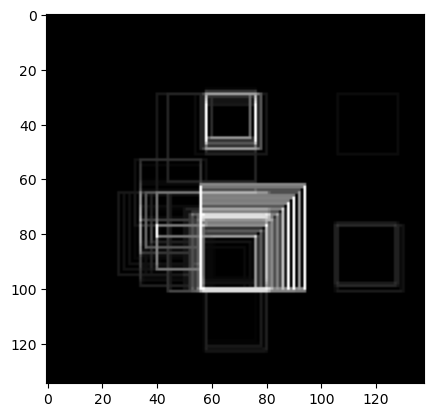

In [402]:
imshow(final_rec_img)

<AxesSubplot:>

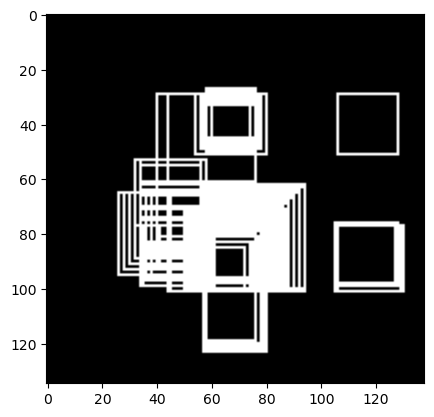

In [417]:

imshow(pt.where(final_rec_img > 0.01, 1, 0))

## Nałożenie wyniku na obrazek wejściowy

<AxesSubplot:>

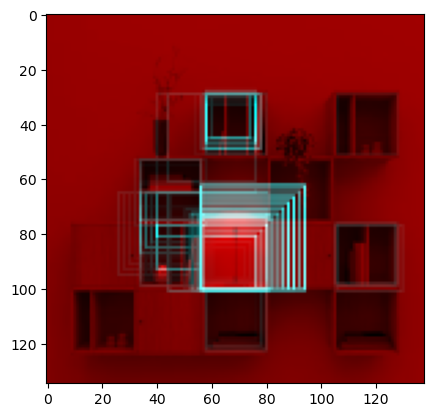

In [407]:
res = pt.stack([
    pooled_img, 
    final_rec_img.reshape(1, *final_rec_img.shape),
    final_rec_img.reshape(1, *final_rec_img.shape),
    # pooled_img
]).squeeze()

imshow(res.permute(1, 2, 0))

## Wnioski

Metodzie udalo sie znalezc czesc kwadratow, jednak duza czesc zostala ledwo wykryta, lub wykryta wielokrotnie.

Na pewno mozna wymislic lepszy sposob, na dobor kryteriow filtrowania wynikowych obrazkow posrednich. Metoda na "oko" pozostawia wiele do zyczenia, jak i wymaga recznego ustawiania thresholdow.